# Generate towers
The purpose of this notebook is to generate a set of towers, evaluate them according to basic metrics and to save them to disk.

See also:
* `analysis/tower selection analysis.ipynb`. This notebook is superseded by it.
* `stimuli/score_towers.py` to score towers in an efficient manner.

In [13]:
import tower_generator

import tqdm

import pickle

import math

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from utils.blockworld_library import *
from utils.blockworld import *

from model.BFS_Lookahead_Agent import BFS_Lookahead_Agent
from model.BFS_Agent import BFS_Agent
from model.Astar_Agent import Astar_Agent
from model.Best_First_Search_Agent import Best_First_Search_Agent

In [5]:
block_library = bl_nonoverlapping_simple


In [6]:
generator = tower_generator.TowerGenerator(8, 8,
                                           block_library=block_library,
                                           seed=42,
                                           padding=(2, 0),
                                           num_blocks=lambda: random.randint(4, 10), #  flat random interval of tower sizes (inclusive)
                                           )


In [7]:
NUM_TOWERS  = 64
towers = []
for i in tqdm.tqdm(range(NUM_TOWERS)):
    towers.append(generator.generate())

100%|██████████| 64/64 [00:07<00:00,  8.47it/s] 


In [8]:
# look at towers
def visualize_towers(towers, text_parameters=None):
    fig,axes = plt.subplots(math.ceil(len(towers)/5),5,figsize=(20,15*math.ceil(len(towers)/20)))
    for axis, tower in zip(axes.flatten(),towers):
        axis.imshow(tower['bitmap']*1.0)
        if text_parameters is not None:
            if type(text_parameters) is not list:
                text_parameters = [text_parameters]
            for y_offset,text_parameter in enumerate(text_parameters):
                axis.text(0,y_offset*1.,str(text_parameter+": "+str(tower[text_parameter])),color='gray',fontsize=20)
    plt.tight_layout()
    plt.show()

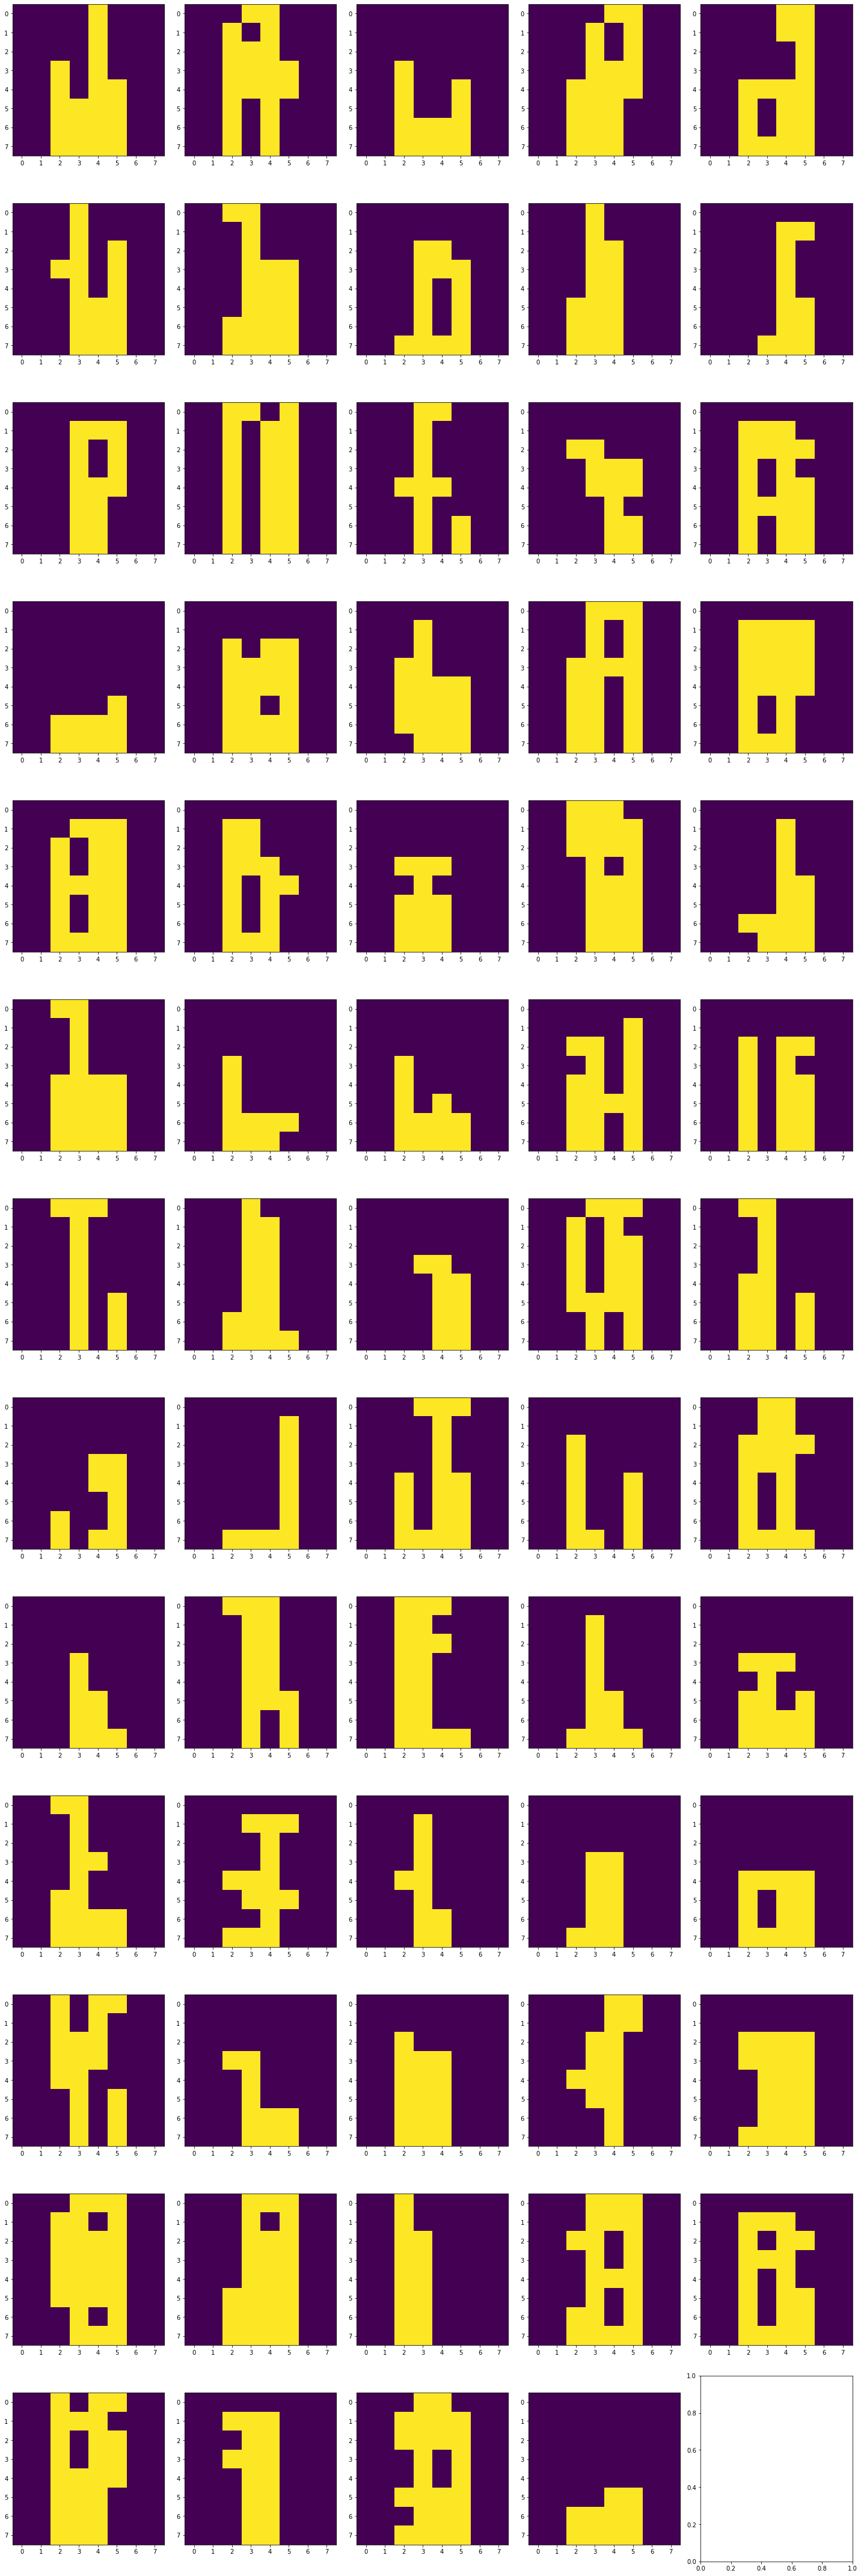

In [9]:
visualize_towers(towers)

In [10]:
# pickle the towers
pickle.dump(towers,open('generated_towers.pkl','wb'))

## Analyze towers

In [11]:
# calculate a few additional metrics
for tower in towers:
    tower['number of blocks'] = len(tower['blocks'])

In [12]:
def get_tower_cost(agent,tower):
    cost = 0
    world = Blockworld(silhouette=tower['bitmap'],
                       block_library=tower['block_library'],
                       physics=True,
                       legal_action_space=True)
    agent.set_world(world)
    while world.status()[0] == 'Ongoing':
        _,step_info = agent.act()
        cost += step_info['states_evaluated']
    return cost,world.status()
    

In [14]:
BFS_builder = BFS_Agent(random_seed=42)
Astar_builder = Astar_Agent(random_seed=42)
Best_first_builder = Best_First_Search_Agent(random_seed=42)

In [ ]:
for tower in tqdm.tqdm(towers):
    BFS_cost,BFS_status = get_tower_cost(BFS_builder,tower)
    Astar_cost,Astar_status = get_tower_cost(Astar_builder,tower)
    tower['A* cost'] = Astar_cost
    tower['BFS cost'] = BFS_cost
    tower['A* success'] = Astar_status[0] == 'Win'
    tower['BFS success'] = BFS_status[0] == 'Win'

In [ ]:
# pickle the towers
pickle.dump(towers,open('generated_evaluated_towers.pkl','wb'))

In [ ]:
# load towers again
towers = pickle.load(open('generated_evaluated_towers.pkl','rb'))

Add percentiles

In [ ]:
Astar_percentiles = [np.percentile([c['A* cost'] for c in towers], i)
               for i in [33, 66, 99]]

# which percentile is each tower in?
for i,tower in enumerate(towers):
    if tower['A* cost'] < Astar_percentiles[0]:
        tower['A* percentile'] = 'easy'
    elif tower['A* cost'] < Astar_percentiles[1]:
        tower['A* percentile'] = 'med'
    else:
        tower['A* percentile'] = 'hard'

BFS_percentiles = [np.percentile([c['BFS cost'] for c in towers], i)
                     for i in [33, 66, 99]]

# which percentile is each tower in?
for i, tower in enumerate(towers):
    if tower['BFS cost'] < BFS_percentiles[0]:
        tower['BFS percentile'] = 'easy'
    elif tower['BFS cost'] < BFS_percentiles[1]:
        tower['BFS percentile'] = 'med'
    else:
        tower['BFS percentile'] = 'hard'


Plot costs

In [ ]:
# we need the same bins for both plots
max_cost = max([max(c['A* cost'],c['BFS cost']) for c in towers])
bins = np.linspace(0,max_cost,500)

plt.hist([c['BFS cost'] for c in towers],
            bins=bins,
            color='purple',
            label='BFS'
)
plt.hist([c['A* cost'] for c in towers],
            bins=bins,
            edgecolor='orange',
            color='orange',
            alpha=0.5,
            label='A*'
)

# make scales logarithmic
# plt.xscale('log')
plt.xscale('log')
plt.title('Cost of building towers')
plt.xlabel('Cost in number of states evaluated')
plt.ylabel('Number of towers')
plt.legend()
plt.show()

In [ ]:
visualize_towers(towers,text_parameters=['A* percentile','A* cost','BFS cost','number of blocks'])

Let's break the towers into separate groups

### A*

In [ ]:
# sort towers according to difficulty
towers.sort(key=lambda x: x['A* cost'])

In [ ]:
for group in ['easy','med','hard']:
    print(group)
    _towers = [t for t in towers if t['A* percentile'] == group]
    visualize_towers(_towers,['A* percentile','A* cost', 'number of blocks'])

### BFS

In [ ]:
# sort towers according to difficulty
towers.sort(key=lambda x: x['BFS cost'])

In [ ]:
for group in ['easy','med','hard']:
    print(group)
    _towers = [t for t in towers if t['BFS percentile'] == group]
    visualize_towers(_towers,['BFS percentile','BFS cost', 'number of blocks'])

In [ ]:
# save towers into dataframe for seaborn (probably should do that anyways)
towers_df = pd.DataFrame(towers)

### Scatter plot between different costs

In [ ]:
g = sns.scatterplot(data = towers_df,x='A* cost',y='BFS cost',
hue='number of blocks',
)
g.set_xscale('log')
g.set_yscale('log')
g.set_title("Comparing A* and BFS cost for towers")
plt.gcf().set_size_inches(8,5)
plt.show()

In [ ]:
g = sns.stripplot(data = towers_df,x='number of blocks',y='BFS cost',
hue='number of blocks',
)
g.set_yscale('log')
g.set_title("Cost over number of blocks from tower generation")
plt.show()

g = sns.stripplot(data=towers_df, x='number of blocks', y='A* cost',
                  hue='number of blocks',
                  )
g.set_yscale('log')
g.set_title("Cost over number of blocks from tower generation")
plt.show()
